In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import os, sys
import librosa as lb
from os import listdir
from os.path import isfile, join
%matplotlib inline

class File_charge:
    """
    La classe File_charge permet d'instancier un objet de type dataframe contenant les chemins d'accès des fichiers audio
    contenus dans chaque sous dossier du dataset
    """
    def __init__(self, path):
        self.path = path 
        
    def load_file(self):
        """
        La fonction load_file retourne un dataframe constituer des chemins d'accès aux fichiers audio contenu 
        dans un sous dossier du dataset     
        """        
        dirs = os.listdir(self.path)
        df = list()
        for dir in dirs:
            df.append((self.path+"/"+dir))

        df = pd.DataFrame(df, columns = ['audio_file'])
        return  df

#Importation des données

machine_id="01"
machine_id_int=1
machine_id2="03"
machine_id_int2=3

nb_pixels=32
mel_bins=128
nb_img=10 #(calculé dans le code "Conversion des fichiers audio en images")

"""
Changer le nom des dossiers dans lesquels ont été importés les images normalisées des spectrogrammes log mel
"""

train_path="C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/ToyCar_train_img_normalized/id_"+machine_id
train_path2="C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/Toycar_train_img_normalized/id_"+machine_id2
test_path="C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/ToyCar_test_img_normalized/id_"+machine_id

File_train=pd.read_csv('ToyCar_train_img_normalized/fichier_ToyCar_train.csv')
File_test=pd.read_csv('ToyCar_test_img_normalized/fichier_ToyCar_test.csv')
File_train=File_train[(File_train['machine_id']==machine_id_int) | (File_train['machine_id']==machine_id_int2)]
File_train=File_train.set_index([pd.Index(np.arange(len(File_train)))])
File_test=File_test[File_test['machine_id']==machine_id_int]
File_test=File_test.set_index([pd.Index(np.arange(len(File_test)))])

df_train = File_charge(train_path)
df_train = df_train.load_file()
df_test = File_charge(test_path)
df_test = df_test.load_file()

df_train2 = File_charge(train_path2)
df_train2 = df_train2.load_file()

#A dé-commenter si on souhaite joindre les ID

#df_train=pd.concat([df_train,df_train2],axis=0)

test_list=[]
erreur=0
red=2
X_train=np.ndarray((len(df_train)//red,nb_pixels,mel_bins))
X_test=np.ndarray((len(df_test)//red,nb_pixels,mel_bins))

#Les images d'entrainement peuvent être sélectionnées de manière random car elle ont toutes le même label
for j in range(len(df_train)//red): ##Set de données réduit pour tester l'autoencodeur
    i=random.choice(range(len(df_train))) #On choisit les images aléatoirement
    if (np.loadtxt(df_train.iloc[i,0], delimiter =', ').shape==(nb_pixels,mel_bins)):
        X_train[j,:,:]=np.loadtxt(df_train.iloc[i,0], delimiter =', ')
    else: erreur+=1

print('Erreurs train=', erreur)
erreur=0
                        
#Les images de test sont groupées par extrait car il ne faut pas mélanger les images normales et anormales 
for j in range(len(df_test)//red//nb_img):##Set de données réduit pour tester l'autoencodeur
    i=random.choice(range(len(df_test)//nb_img)) #On sélectionne un extrait au hasard
    test_list+=[i]
    for t in range(nb_img):
            if (np.loadtxt(df_test.iloc[nb_img*i,0], delimiter =', ').shape==(nb_pixels,mel_bins)):
                X_test[(nb_img)*j+t,:,:]=np.loadtxt(df_test.iloc[nb_img*i+t,0], delimiter =', ')
            else: erreur+=1
        
print('Erreurs test=', erreur)

Erreurs train= 0
Erreurs test= 0


<AxesSubplot:>

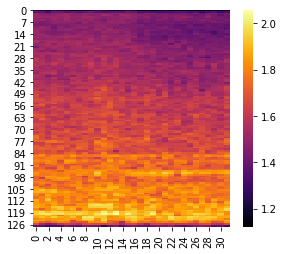

In [35]:
import seaborn as sns
plt.figure(figsize=(15,4))
plt.subplot(131)
X_train_plot = X_train.reshape([X_train.shape[0],nb_pixels,mel_bins])
sns.heatmap(np.rot90(X_train_plot[250,:,:]), cmap='inferno')

In [21]:
X_train.shape


(2500, 32, 128)

In [2]:
#Mise en forme des tenseurs

X_train_batch = X_train.reshape([X_train.shape[0],nb_pixels,mel_bins,1])
X_test_batch = X_test.reshape([X_test.shape[0],nb_pixels,mel_bins,1]) 

batchsize=250

dataset_train = tf.data.Dataset.from_tensor_slices(X_train_batch)
dataset_train = dataset_train.batch(batch_size=batchsize)

dataset_test = tf.data.Dataset.from_tensor_slices(X_test_batch) 
dataset_test = dataset_test.batch(batch_size=1)

In [3]:
#Modele d'autoencodeur
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder_decoder = tf.keras.Sequential([
                 tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5),input_shape=(nb_pixels,mel_bins,1), activation='relu', padding='same'),
                 tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                 tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
                 tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                 tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
                 tf.keras.layers.MaxPool2D(pool_size=(2,2)),
                 tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
                 tf.keras.layers.UpSampling2D(size=(2,2)),
                 tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
                 tf.keras.layers.UpSampling2D(size=(2,2)),
                 tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5,5),activation='relu', padding='same'),
                 tf.keras.layers.UpSampling2D(size=(2,2)),                
                 tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3),activation='sigmoid', padding='same')                
                            ])
    def call(self, input_features):
        reconstructed = self.encoder_decoder(input_features)
        return reconstructed

#Calcul de l'erreur de reconstruction
def loss(model, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(tf.cast(model(original),dtype=tf.float64),tf.cast(original,dtype=tf.float64))))
    return reconstruction_error

#Définition de l'entrainement
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

#Fonctions de post-processing
def predict(model, data, threshold):
    rec_loss = loss(model, data).numpy()
    return tf.math.less(rec_loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = ",np.round(accuracy_score(labels, predictions),3))
    print("Precision = ",np.round(precision_score(labels, predictions),3))
    print("Recall = ",np.round(recall_score(labels, predictions),3))


epoch= 0
mean loss = 0.0404
deviation = 0.0
mean loss = 0.0321
deviation = 0.002415
epoch= 1
mean loss = 0.0163
deviation = 0.004434
mean loss = 0.0164
deviation = 0.000538
epoch= 2
mean loss = 0.0145
deviation = 0.000393
mean loss = 0.0136
deviation = 0.00042
epoch= 3
mean loss = 0.0121
deviation = 0.000412
mean loss = 0.0117
deviation = 0.000312
epoch= 4
mean loss = 0.0104
deviation = 0.000375
mean loss = 0.01
deviation = 0.0003
epoch= 5
mean loss = 0.0087
deviation = 0.000361
mean loss = 0.0082
deviation = 0.000299
epoch= 6
mean loss = 0.0069
deviation = 0.000367
mean loss = 0.0062
deviation = 0.000323
epoch= 7
mean loss = 0.005
deviation = 0.000349
mean loss = 0.0046
deviation = 0.000198
epoch= 8
mean loss = 0.0041
deviation = 0.000157
mean loss = 0.004
deviation = 0.000122
epoch= 9
mean loss = 0.0037
deviation = 0.000109
mean loss = 0.0037
deviation = 0.000105
epoch= 10
mean loss = 0.0034
deviation = 9.7e-05
mean loss = 0.0035
deviation = 9.9e-05
epoch= 11
mean loss = 0.0032
devia

ValueError: x and y must have same first dimension, but have shapes (30,) and (600,)

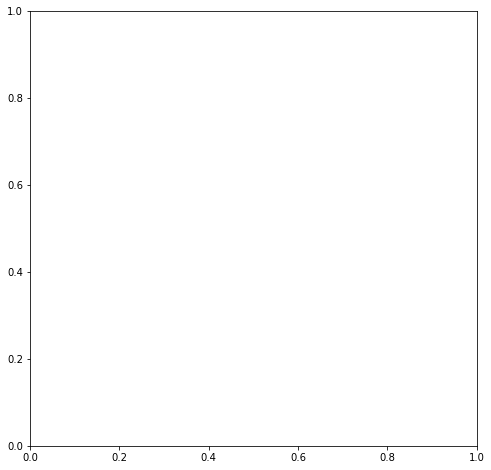

In [4]:
#Paramètres d'entrainement
epochs=30
learning_rate=1e-4
        
#Instanciation
autoencoder = Autoencoder()
opt = tf.optimizers.Adam(learning_rate=learning_rate)
loss_e=[]
loss_v=[]

#ici on décompose l'entrainement, mais on pourait faire appel à la fonction fit car Autoencoder hérite de Model
for epoch in range(epochs):
    print('epoch=',epoch)
    for step, batch_features in enumerate(dataset_train):
        train(loss, autoencoder, opt, batch_features)
        loss_values = loss(autoencoder, batch_features)
        loss_v+=[loss_values.numpy()]
        if (step%10==0):
            print('mean loss =', np.round(loss_values.numpy(),4))    
            print('deviation =',np.round(np.std(loss_v[-10:]),6))
    loss_e+=[loss_values.numpy()]
            
plt.figure(figsize=(8,8))
plt.plot(range(0,epoch+1),loss_e)                

autoencoder.save_weights('C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/TrainingAE/checkpoints/'+machine_id+'/my_checkpoint')

In [ ]:
#Repartir d'un modèle sauvegardé

autoencoder = Autoencoder()
autoencoder.load_weights('C:/Users/Quasarlight/Desktop/Formation data/Projet/Donnees_sonores/TrainingAE/checkpoints/'+machine_id+'/my_checkpoint')
epochs=20
learning_rate=1e-3
        
#Instanciation
opt = tf.optimizers.Adam(learning_rate=learning_rate)
loss_e=[]

#ici on décompose l'entrainement, mais on pourait faire appel à la fonction fit car Autoencoder hérite de Model
for epoch in range(epochs):
    print('epoch=',epoch)
    for step, batch_features in enumerate(dataset_train):
        train(loss, autoencoder, opt, batch_features)
        loss_values = loss(autoencoder, batch_features)
        if (step==1):
            print('mean loss =', np.round(loss_values.numpy(),4)) 
            loss_e+=[loss_values.numpy()]

plt.figure()
plt.plot(loss_e,range(1,epoch+1))

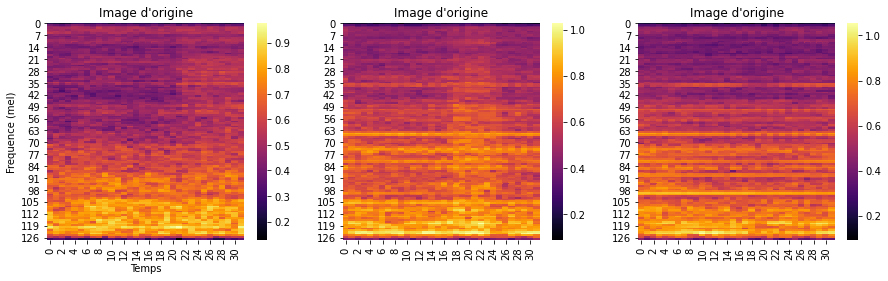

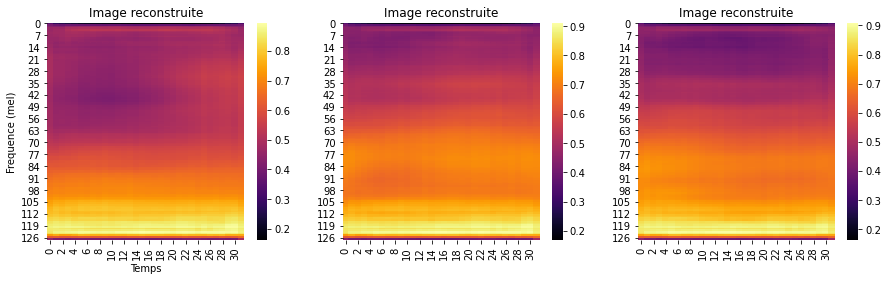

Training loss =  0.0023647389437087205


In [5]:
#Comparaison entrée sortie pour vérifier le bon fonctionnement de l'encodeur

reconstructions = autoencoder.predict(dataset_train)
X_train_plot = X_train.reshape([X_train.shape[0],nb_pixels,mel_bins])
reconstructions_plot = reconstructions.reshape([X_train.shape[0],nb_pixels,mel_bins])

i=random.choice(range(X_train.shape[0]))

plt.figure(figsize=(15,4))
plt.subplot(131)
sns.heatmap(np.rot90(X_train_plot[i,:,:]), cmap='inferno')
plt.title("Image d'origine")
plt.xlabel('Temps')
plt.ylabel('Frequence (mel)')
plt.subplot(132)
sns.heatmap(np.rot90(X_train_plot[i+1,:,:]), cmap='inferno')
plt.title("Image d'origine")
plt.subplot(133)
sns.heatmap(np.rot90(X_train_plot[i+2,:,:]), cmap='inferno')
plt.title("Image d'origine")
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(131)
sns.heatmap(np.rot90(reconstructions_plot[i,:,:]), cmap='inferno')
plt.title("Image reconstruite")
plt.xlabel('Temps')
plt.ylabel('Frequence (mel)')
plt.subplot(132)
sns.heatmap(np.rot90(reconstructions_plot[i+1,:,:]), cmap='inferno')
plt.title("Image reconstruite")
plt.subplot(133)
sns.heatmap(np.rot90(reconstructions_plot[i+2,:,:]), cmap='inferno')
plt.title("Image reconstruite")
plt.show()

train_loss=0
for i in range(reconstructions.shape[0]):
    train_loss += tf.reduce_mean(tf.square(tf.subtract(tf.cast(reconstructions_plot[i,:,:],dtype=tf.float64),tf.cast(X_train_plot[i,:,:],dtype=tf.float64))))
train_loss/=reconstructions.shape[0]
print('Training loss = ',train_loss.numpy())

Threshold 0.0024
Threshold 0.0026
Threshold 0.0028
Threshold 0.0031
Threshold 0.0033
Threshold 0.0035
Threshold 0.0038
Threshold 0.004
Threshold 0.0043
Threshold 0.0045


Text(0.5, 1.0, 'Recall')

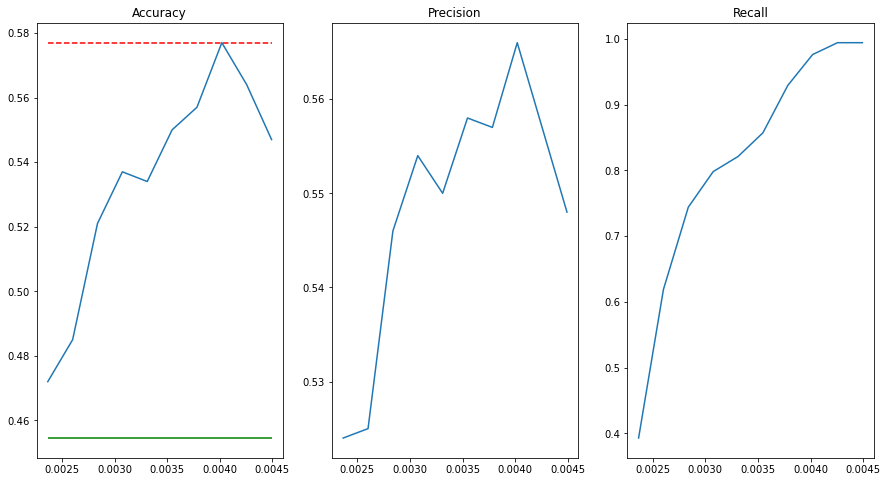

In [9]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

losses=[]
accuracy=[]
precision=[]
recall=[]
thresholds=[]
nb_test=10
test_labels=np.ndarray((len(X_test)//(nb_img)+1,1),bool)

#Extraction du vecteur de labels 

for i in range(len(test_list)):
    test_labels[i]=File_test['label'][test_list[i]]

#Calcul des prédictions et des métriques pour différentes valeurs de seuil

for x in range(0,10):
    threshold=(train_loss)*(1+x/10) 
    thresholds+=[threshold]
    preds_img=np.ndarray((len(X_test)+1,1),bool)
    losses=[]
    preds=np.ndarray(((len(X_test)//(nb_img)+1),1),bool)

    i=0
    for features in dataset_test:
        preds_img[i] = predict(autoencoder,features,threshold)
        losses+=[loss(autoencoder,features).numpy()]
        i+=1
        if (i%nb_test==0):
            if(sum(preds_img[i-nb_test:i-1])>(nb_test-3)):
                preds[i//nb_test-1]=True
            else:
                preds[i//nb_test-1]=False
            
    print('Threshold',np.round(threshold.numpy(),4))    
    accuracy+=[np.round(accuracy_score(test_labels[:-1],preds[:-1]),3)]
    precision+=[np.round(precision_score(test_labels[:-1],preds[:-1]),3)]
    recall+=[np.round(recall_score(test_labels[:-1],preds[:-1]),3)]

#Tracé des métriques

plt.figure(figsize=(15,8))
plt.subplot(131)
plt.plot(thresholds,accuracy)
plt.hlines(1-test_labels.sum()/len(test_labels),thresholds[0],thresholds[len(thresholds)-1],'g',label='proportion True/Total')
plt.hlines(np.max(accuracy),thresholds[0],thresholds[len(thresholds)-1],'r',linestyles= 'dashed',label='max accuracy')
plt.title('Accuracy')
plt.subplot(132)
plt.plot(thresholds,precision)
plt.title('Precision')
plt.subplot(133)
plt.plot(thresholds,recall)
plt.title('Recall')

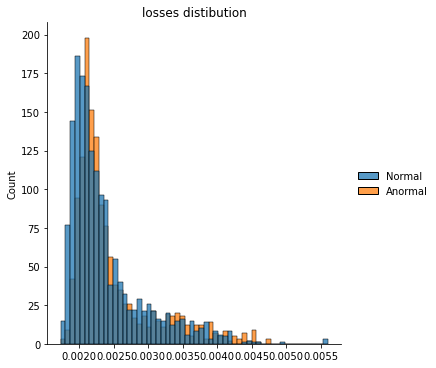

In [11]:
#Tracé de la répartition des errreus de reconstruction

test_labels_plot=[]
for n in range(len(test_labels)):
    if test_labels[n]==True:
        for i in range(nb_test):
            test_labels_plot+=['Normal']
    else:
        for i in range(nb_test):
            test_labels_plot+=['Anormal']

sns.displot(x=losses,hue=test_labels_plot[0:len(losses)],kind="hist")
plt.title('losses distibution')
plt.show();

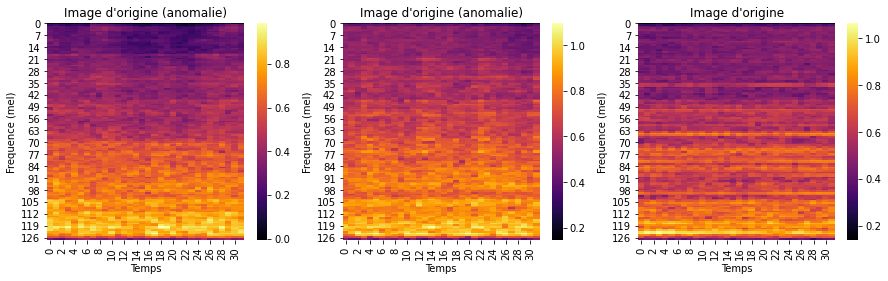

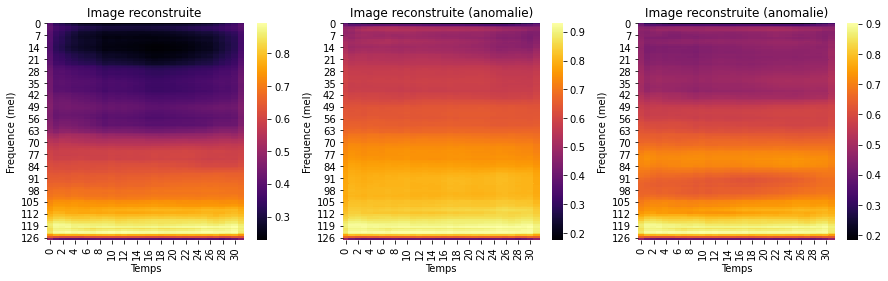

In [51]:
#Tracé d'anomalies

reconstructions = autoencoder.predict(dataset_test)
X_test_plot = X_test.reshape([X_test.shape[0],nb_pixels,mel_bins])
reconstructions_plot = reconstructions.reshape([X_test.shape[0],nb_pixels,mel_bins])

anomalies=[]
for x in range(len(test_list)):
    if (File_test['label'][test_list[x]]==False):
        anomalies+=[x]

i=random.choice((anomalies))

plt.figure(figsize=(15,4))
plt.subplot(131)
sns.heatmap(np.rot90(X_test_plot[i,:,:]), cmap='inferno')
plt.title("Image d'origine (anomalie)")
plt.xlabel('Temps')
plt.ylabel('Frequence (mel)')

j=random.choice((anomalies))
plt.subplot(132)
sns.heatmap(np.rot90(X_test_plot[j,:,:]), cmap='inferno')
plt.title("Image d'origine (anomalie)")
plt.xlabel('Temps')
plt.ylabel('Frequence (mel)')

k=random.choice((anomalies))
plt.subplot(133)
sns.heatmap(np.rot90(X_test_plot[k,:,:]), cmap='inferno')
plt.title("Image d'origine")
plt.xlabel('Temps')
plt.ylabel('Frequence (mel)')

plt.show()

plt.figure(figsize=(15,4))
plt.subplot(131)
sns.heatmap(np.rot90(reconstructions_plot[i,:,:]), cmap='inferno')
plt.title("Image reconstruite ")
plt.xlabel('Temps')
plt.ylabel('Frequence (mel)')

plt.subplot(132)
sns.heatmap(np.rot90(reconstructions_plot[j,:,:]), cmap='inferno')
plt.title("Image reconstruite (anomalie)")
plt.xlabel('Temps')
plt.ylabel('Frequence (mel)')

plt.subplot(133)
sns.heatmap(np.rot90(reconstructions_plot[k,:,:]), cmap='inferno')
plt.title("Image reconstruite (anomalie)")
plt.xlabel('Temps')
plt.ylabel('Frequence (mel)')
plt.show()



In [1]:
threshold=train_loss*(1-12/100) 
preds_img=np.ndarray((len(X_test)+1,1),bool)
preds=np.ndarray(((len(X_test)//(nb_img)+1),1),bool)
i=0

for features in dataset_test:
    preds_img[i] = predict(autoencoder,features,threshold)
    i+=1
    if (i%nb_test==0):
        if(sum(preds_img[i-nb_test:i-1])>3):
            preds[i//nb_test-1]=True
        else:
            preds[i//nb_test-1]=False
            
print('accuracy =', np.round(accuracy_score(test_labels[:-1],preds[:-1]),3))
print('precision = ', np.round(precision_score(test_labels[:-1],preds[:-1]),3))
print('recall = ', np.round(recall_score(test_labels[:-1],preds[:-1]),3))

NameError: name 'train_loss' is not defined

In [22]:
for i in range(20):
    print('Prediction ',preds[i],'   Label ',test_labels[i])

array([[False],
       [ True],
       [False],
       [ True],
       [False]])